# ASSIGNMENT 3                                                McGill COMP451 - Fall 2022
### Ali Hazime (McGill ID 260920680) - **Kaggle ID 12339233**
#### To the TA correcting my assignment, please note that I didn't use a random seed so you might get a slightly different accuracy if you decide to run the cells and it will take ~3-4 minutes to train the model. Also, you will notice that I used a lot of code from the website https://jovian.ai/aakashns/05-cifar10-cnn to help me build the model.


If you discussed solutions with any of your classmates please list their name here. You should not share any code with your classmates, but you can discuss your solution. This is an individual assignment. The team ID above is only needed because we need to link your report to your Kaggle submission.

**Note:** you can only use late days to submit the report (which has 5/20 pts). The competition, which is the main part of this assignment (15/20 pts), will close at the exact submission deadline. So please start early! 

## Objective
The objective of this assignment is to give you hands-on experience with deep learning packages, such as pyTorch. The task here is to build a model that takes an image as input and produces a single number. The image contains three digits consisting only of digits 1,2 and 3. The output of the model should be the product of these digits. It is up to you to choose the model architecture. You may choose to first predict each digit and then calculate their product, or calculate the product in one shot. You may approach this as a classification task since the output options are limited, or consider it as a regression task. The assignment has two deliverables: 
- you need upload your prediction for the test set to Kaggle in order to participate in the competition
- you need to complete this notebook which is considered a report of your methodolgoy

# Kaggle Competition
You get access to the Kaggle competition using the following private url
[https://www.kaggle.com/t/e4c5b440119c4116b2128e4c3dbb8e58](https://www.kaggle.com/t/e4c5b440119c4116b2128e4c3dbb8e58)
Training and test data are available as a part of the assignment in the datasets folder. To participate in the competition you should upload a CSV file containing your predicted label for the entire test data to Kaggle. 
The test data is divided in half. You receive the correct label for the first half (in datasets folder), so that you can evaluate your model in this notebook on that part of the test set. You then submit your solution for the entire test set to Kaggle. The final evaluation is based on your predictions for the second part of the test set (private leaderboard). We have step-by-step explanation in the final section of this notebook.

# Report
The purpose of this notebook is for you to provide a concise report of your methodology. That is you need to include all steps necessary to reproduce your results. Please include high level explanation of the implementation so that we can understand what you're trying to achieve in each piece of the code.

**Note:** You need to submit this notebook where you have run all the cells as part of Assignment 3. **We should not need to rerun your code since this can take a long time.** You can use your Google cloud credit towards this assignment, to get better GPU access for example, using Google colab. Ask for help if you want to do this.

## Grading (20 pts)
The grading for this assignment has two components
- **Performance in the private leaderboard** (**15 pts**)
    - Have you correctly implemented a **deep model** and correctly trained in on the dataset (**5pts**). Note that this means your solution discussed in this report has to be a deep model, implemented using automatic differentiation packages such as pyTorch, Jax or Tensorflow.
    - a linear grade based on your relative accuracy: $10 \times \frac{acc_{you}}{acc_{best}}$ -- where $acc_{best}$ is the accuracy of the best model in our class (**10pts**). So if you have 40% accuracy on the private leaderboard and the best model has 80% accuracy, you will receive $10\times \frac{40}{80} = 5$ points.
    -  Top 5 participants in the private leaderboard receive a bonuses of 10, 8, 6, 4, 2 pts. If your total grade is over 20pts your bonus will be carried over to your final grade.
- **Quality of Your Report** (**5pts**)
    - Is your report clear and concise? 
    - do you have a minimal yet clear explanation for each step? Also, if you are using routines that are trivial and can be separated into a another python file you can do this in favour of better readability and minimality of the notebook. 
    - Do your design choices make sense? Are they justified?
    - If you tried several ideas, try to focus your report on the final one that is used in your final submission. You can quickly mention what other ideas you tried and discarded if that is the case.

**Note:** if the results in the final part of this report does not match the CSV file that you uploaded to Kaggle you will not receive any points for this entire assignment.

## Step 1 - the dataset
Use the following code to load the data using the npy files. We have 11,000 training examples, where each image is 64x64. Labels are the product of numbers in each image. The label is printed at the top of each example shown below.

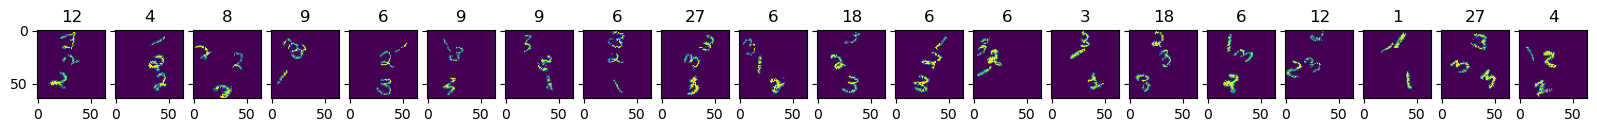

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid                         #To plot the images in grid and we have seen it before 

x = np.load('datasets/x_train.npy') #11,000 x 64 x 64
y = np.load('datasets/y_train.npy')
def plot_digits(x,y):
    num_plots = x.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(x[i].reshape((64,64)))
        grid[i].set_title(str(y[i]))
    plt.show()
plot_digits(x[:20], y[:20])  #plot 20 first instances in the dataset 

## Step 2 - preprocessing 

Your report should contain any potential preprocessing that you have done on the dataset. If you haven't performed any preprocessing, please leave this empty. This includes any sample code that you will use. 

In [26]:
# Import all libraries needed
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

In [27]:
# Preprocessing the dataset

# helper function to encode y so that it becomes a numpy array with elements from 0 to 9
def encode(y):
    # initial labels = 1, 2, 3, 4, 6, 8, 9, 12, 18, 27
    # new labels = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
    y_duplicate = np.copy(y)
    possible_labels = [1, 2, 3, 4, 6, 8, 9, 12, 18, 27]
    for i in range(10):
        y[y_duplicate == possible_labels[i]] = i
    return y
    
# helper function to decode y after making the prediction for the labels
def decode(y):
    y_duplicate = np.copy(y)
    possible_labels = [1, 2, 3, 4, 6, 8, 9, 12, 18, 27]
    for i in range(10):
        y[y_duplicate == i] = possible_labels[i]
    return y

x = torch.as_tensor(x.reshape(11000,1,64,64), dtype=torch.float) #reshape matrix to N x Channel x Width x Height
y = torch.as_tensor(encode(y))

# split the training set of 11000 images so that n_train= 8800 and n_validation = 2200 (80:20 ratio)
# At the begininng, I tried n_train=10000 and n_validation=1000 but it resulted in less accuracy
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
n_train = x_train.shape[0]
n_val = x_val.shape[0]

# Step 3 - the model and its training
This is the main part of your report. Below we provide an example, where we apply a logistic regression model to the dataset, and we get a very bad accuracy. You can do much better! You also have to use a deep learning package in your solution. Provide the explanation for your model and its training below. 

## 3.1 example code (not using pyTorch)
The code below shows the performance of a logistic regression model which will be used as a base model in this case. 

In [2]:
# Prof's example: No need to run it!
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
features = x.reshape(11000,-1) #vectorizing the input image
labels = y.reshape(-1,1)
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.33, random_state=42) #set aside for validation
clf = LogisticRegression()
clf.fit(x_train,y_train)
predictions = clf.predict(x_val)
accuracy = accuracy_score(y_val, predictions)
print("The validation accuracy of the model is", accuracy*100, '%')

The validation accuracy of the model is 16.225895316804408 %


## 3.2 your model!

 You should choose the final learning model that you have used to submit your solutions to Kaggle. For your chosen model provide the implementation code in this notebook along with the detail. Details should include the architecture and the choice of hyperparameters. If you performed a hyperparameter search you should explain it here.

you can start here in the same cell!


I want to emphasize that I heavily used code from the website: https://jovian.ai/aakashns/05-cifar10-cnn while designing my model. The only things that I changed from the code was 1) not use cuda, 2) add more depth to my network, 3) adapt the number of input and output channels for the convolutions, 4) change the value of the hyperparameters and 5) choose which minibatch to take at each training and validation step. I found that the code is relatively straightforward and has similar format to the prof's provided code in previous assignments.

In [28]:
# helper method that computes the accuracy of the outputs (predictions) with respect to the ground truth
# used in the validation step.
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# This class contains the training step and validation step functions that will be used on each mini batch during the learning
# phase. The code uses the built-in F.cross-entropy to compute the loss.
# Also at the end of each epoch, we have a function that prints the average training loss,
# average validation loss and validation accuracy. This helps in analyzing the model at the end.
class ImageClassification(nn.Module):
    def training_step(self, x, y):
        out = self(x)                  # Generate the predictions of labels
        loss = F.cross_entropy(out, y) # Calculate the cross entropy loss
        return loss
    
    def validation_step(self, x, y):
        out = self(x)                    # Generate the predictions of labels
        loss = F.cross_entropy(out, y)   # Calculate the cross entropy loss
        acc = accuracy(out, y)           # Calculate the accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc} #store in dict
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Take the mean of the losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Take the mean of the accuracies 
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()} #store in dict
    
    def epoch_end(self, epoch, result): # Print the result at the end of each epoch
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

The template used for the neural network below was also taken from the website: https://jovian.ai/aakashns/05-cifar10-cnn. However, like I said before, I made some changes which I will explain below.
For the activation function, I used ReLu since we learned in the lecture that "replacing logistic with ReLU significantly improves the training of deep networks".
For the feature learning part, I wanted my network to have reasonable depth (more than what was provided in the website).
We start with a 64 x 64 image and we want to reach an output of 4 x 4 (my choice) for the width and height after all the max pooling, so in total, we can only do 4 times 2x2 pooling (64 x 64 -> 32 x 32 -> 16 x 16 -> 8 x 8 -> 4 x 4). 
So I decided to do two convolutions and two ReLu activations before each pooling, which gives a network of depth 8 
(2 convolutions/pooling x 4 poolings = 8 convolutions).
Now, for the convolutions, I realized I cannot go beyond 128 channels due to a lack of space (I get an error message). And we have 8 convolutions in total. So my design choice was the following: 
- Convolution 1: We input 1 channel and output 8 channels
- Convolution 2: We input 8 channels and output 16 channels
- Convolution 3: We input 16 channels and output 32 channels
- Convolution 4: We input 32 channels and output 32 channels
- Convolution 5: We input 32 channels and output 64 channels
- Convolution 6: We input 64 channels and output 64 channels
- Convolution 7: We input 64 channels and output 128 channels
- Convolution 8: We input 128 channels and output 128 channels

Throughout the convolutions, we keep the size of the kernel=3x3 and the padding=1 since they seem to be a popular choice. 
Now, after the convolutions and the max pooling, we reach the classification part. We flatten the output of size 128 x 4 x 4 and apply a linear function 2 times with decreasing matrix size (2048 -> 512 -> 10) until we get an output of
10 features. 
Note that the output represents a vector of label probabilities for each image in the minibatch, so we need a function like softmax to get the prediction for the labels afterwards.

In [29]:
class CnnModel(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  # C_in=1, C_out=8, kernel=3x3, padding=1
            nn.ReLU(),   # Activation function: Rectified Linear Unit (ReLU)
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),  # C_in=8, C_out=16, kernel=3x3, padding=1
            nn.ReLU(), 
            nn.MaxPool2d(2, 2), # output.shape= 16 x 32 x 32

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # C_in=16, C_out=32, kernel=3x3, padding=1
            nn.ReLU(),   
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # C_in=32, C_out=32, kernel=3x3, padding=1
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output.shape= 32 x 16 x 16

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # C_in=32, C_out=64, kernel=3x3, padding=1
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), # C_in=64, C_out=64, kernel=3x3, padding=1
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output.shape= 64 x 8 x 8
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # C_in=64, C_out=128, kernel=3x3, padding=1
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # C_in=128, C_out=128, kernel=3x3, padding=1
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output.shape= 128 x 4 x 4

            nn.Flatten(), # flatten the 128 x 4 x 4 output
            nn.Linear(2048, 512), # in_features=128*4*4=2048, out_features=512
            nn.ReLU(),
            nn.Linear(512, 10)) # in_features=512, out_features = number of labels (10)
        
    def forward(self, xb):
        return self.network(xb) # Go through the network described above

Once more, I used code for the functions _evaluate_ and _fit_ from the website: https://jovian.ai/aakashns/05-cifar10-cnn. However, I changed the order of the minibatch chosen for the training and validation step, similarly to what we were required to do for assignment 2 inside the loop "_for i in range (n_train//minibatch)_". The function _predict_ was fully made by me to make the code more modular and less repetitive.
For the choice of hyperparameters, I changed the size of the minibatch from 128 to 64 and it made the model reach a slightly higher accuracy. Also, I kept the initial learning rate 0.001 because the model was converging fast enough. I used 12 as the number of epochs and it looks good enough in the plots at the end. For optimization, the website used Adam (Adaptive Moment Estimation) so I decided to keep it.

In [30]:
#helper function to apply the validation step for each minibatch of size=64
def evaluate(model, x_val, y_val, minibatch):
    model.eval()
    outputs = []
    for i in range (n_val//minibatch):
        # apply the validation step for each minibatch of size=64 starting from the end of x_val and y_val
        xi_val = x_val[n_val - ((i + 1) * minibatch) : n_val - (i * minibatch), :]
        yi_val = y_val[n_val - ((i + 1) * minibatch) : n_val - (i * minibatch)]
        outputs.append(model.validation_step(xi_val, yi_val))
    return model.validation_epoch_end(outputs)

def fit(minibatch, epochs, lr, model, x_train, y_train, x_val, y_val, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for i in range (n_train//minibatch):
            # apply the training step for each minibatch of size=64 starting from the end of x_train and y_train
            xi_train = x_train[n_train - ((i + 1) * minibatch) : n_train - (i * minibatch), :]
            yi_train = y_train[n_train - ((i + 1) * minibatch) : n_train - (i * minibatch)]
            loss = model.training_step(xi_train, yi_train)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, x_val, y_val, minibatch)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def predict(model,x):
    x = torch.as_tensor(x.reshape(x.shape[0],1,x.shape[1],x.shape[2]), dtype=torch.float) 
    # convert x to a tensor with shape = N x 1 x 64 x 64
    
    y_prob_test = model(x)                              # obtain a vector of 10 probabilities for each image
    y_pred_test = (torch.max(y_prob_test, dim=1)).indices    # choose the maximum probability to be the predicted label
    y_pred_test = y_pred_test.numpy()    # convert y_pred back to a numpy array
    y_pred_test = decode(y_pred_test)    # decode y back to the real labels
    return y_pred_test
    
## My choice of hyperparameters for the fit method
num_epochs = 12                  # number of epochs = 12
opt_func = torch.optim.Adam      # Use Adam (Adaptive Moment Estimation) to optimize
lr = 0.001                       # Learning rate = 0.001
minibatch = 64                   # size of minibatch = 64

model = CnnModel()               # Initialize the convolutional neural network model

history = fit(minibatch, num_epochs, lr, model, x_train, y_train, x_val, y_val, opt_func)    
# train the model and print the history of losses and accuracies for each epoch
# the accuracies and losses inside the variable history will be plotted in step 4 for more insight.

Epoch [0], train_loss: 2.0956, val_loss: 1.6189, val_acc: 0.3460
Epoch [1], train_loss: 1.2966, val_loss: 1.1253, val_acc: 0.4995
Epoch [2], train_loss: 1.1368, val_loss: 1.1579, val_acc: 0.5175
Epoch [3], train_loss: 0.8089, val_loss: 0.4800, val_acc: 0.8387
Epoch [4], train_loss: 0.4173, val_loss: 0.3155, val_acc: 0.8957
Epoch [5], train_loss: 0.2602, val_loss: 0.3211, val_acc: 0.9017
Epoch [6], train_loss: 0.1790, val_loss: 0.2716, val_acc: 0.9182
Epoch [7], train_loss: 0.1404, val_loss: 0.3357, val_acc: 0.8980
Epoch [8], train_loss: 0.1041, val_loss: 0.3187, val_acc: 0.9122
Epoch [9], train_loss: 0.0964, val_loss: 0.2981, val_acc: 0.9187
Epoch [10], train_loss: 0.0688, val_loss: 0.3262, val_acc: 0.9274
Epoch [11], train_loss: 0.0777, val_loss: 0.2846, val_acc: 0.9430


# Step 4 - accuracy metrics and CSV submission to Kaggle

Here you can report accuracy metrics for the training and test sets. If you set aside a validation set you can report your accuracy on that set. Other plots such as training-validation loss plot over the training period can also be interesting to see here. A minimum here is the accuracy on the first half of the test set. **this number should match your public leaderboard accuracy**. If this is not the case then your predictions here do not match what you reported on Kaggle and your submission is discarded! This is because otherwise we can't establish that this code was used to produce the result of the leaderboard. Below we show this minimal report for the logistic regression classifier that we trained above.

In [4]:
# Prof's example: No need to run it!
x_test = np.load('datasets/x_test.npy') #9,000 x 64 x 64
x_test_half = x_test[:4500] #the first half for which you have the true labels
y_test_half = np.load('datasets/y_test.npy') #length 4,500: you only have the true lable for the first half of the dataset 

predictions = clf.predict(np.reshape(x_test_half, (4500,-1)))
accuracy = accuracy_score(y_test_half, predictions)
print("The accuracy of the model that should match the public leaderboard accuracy is", accuracy*100, '%')


The accuracy of the model that should match the public leaderboard accuracy is 15.666666666666668 %


In [31]:
# Print the test accuracy that will appear on the public leaderboard.
from sklearn.metrics import accuracy_score

x_test = np.load('datasets/x_test.npy')      # x_test shape = 9,000 x 64 x 64
x_test_half = x_test[:4500]                  # x_test new shape = 4500 x 64 x 64
y_test_half = np.load('datasets/y_test.npy') # y_test shape = 4500 x 1
y_test_half = np.squeeze(y_test_half)        # y_test new shape = 4500

y_pred_test = predict(model, x_test_half)

accuracy = accuracy_score(y_test_half, y_pred_test)   # compare the predicted y with the true labels
print("The accuracy of the model that should match the public leaderboard accuracy is", accuracy*100, '%')

The accuracy of the model that should match the public leaderboard accuracy is 94.5111111111111 %


In order to submit your results to Kaggle you need to provide your predictions in CSV format. The code below shows how we do this for the example of logistic regression above. You can use the same method for your submission. Note that we need you to submit your result for the **entire test set** of size 9000. Your accuracy on the first half will show on the public leaderboard and the second half is on the private leaderboard that will be revealed when the competition is over. Submit the `predicted_labels.csv` to the Kaggle competition!  

In [32]:
# Prof's example: No need to run it!
import pandas as pd #you need to install pandas - also checkout what this package is good for while at it :]
def generate_csv_kaggle(y):
    indexes = np.arange(len(y))
    csv_labels = np.concatenate((indexes.reshape(-1,1), y.reshape(-1,1)),axis=1)
    df = pd.DataFrame(csv_labels,columns=['Id','Category'])
    df['Id'] = df['Id'].astype(str)
    df['Category'] = df['Category'].astype(str)
    df.to_csv('predicted_labels.csv',index=False)
    pass

yh_test = clf.predict(np.reshape(x_test, (9000,-1))) #prediction of the model for the entire training set
generate_csv_kaggle(yh_test)

In [33]:
# Generate the csv file for kaggle
import pandas as pd
def generate_csv_kaggle(y):
    indexes = np.arange(len(y))
    csv_labels = np.concatenate((indexes.reshape(-1,1), y.reshape(-1,1)),axis=1)
    df = pd.DataFrame(csv_labels,columns=['Id','Category'])
    df['Id'] = df['Id'].astype(str)
    df['Category'] = df['Category'].astype(str)
    df.to_csv('predicted_labels.csv',index=False)
    pass

x_test = np.load('datasets/x_test.npy')                  # x_test shape = 9,000 x 64 x 64
yh_test = predict(model, x_test)                         # prediction of the model for the entire test set
generate_csv_kaggle(yh_test)

In [34]:
## Extra: I will show the plot for accuracies and losses:
# Note that the code for these two functions are also taken from https://jovian.ai/aakashns/05-cifar10-cnn
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. Number of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number of epochs');

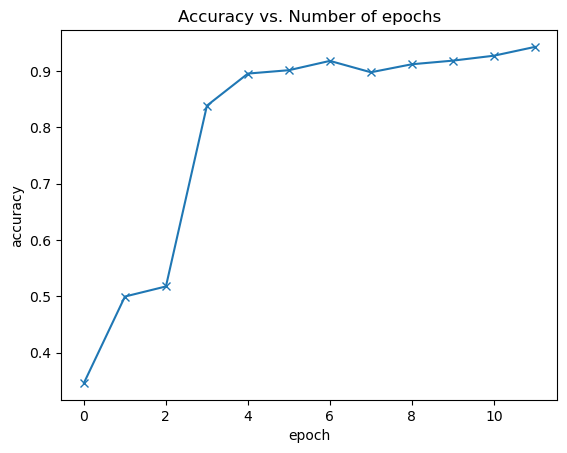

In [35]:
plot_accuracies(history)

In the plot above, we can see that the model has an accuracy of ~94% on the validation set after 12 epochs. And by the looks of things, increasing the number of epochs will not make the model more accurate. To improve the model, one solution would be to go higher than 128 channels when doing convolutions but unfortunately, I ran out of space when I tried an additionnal convolution to go from 128 channels to 256 channels.

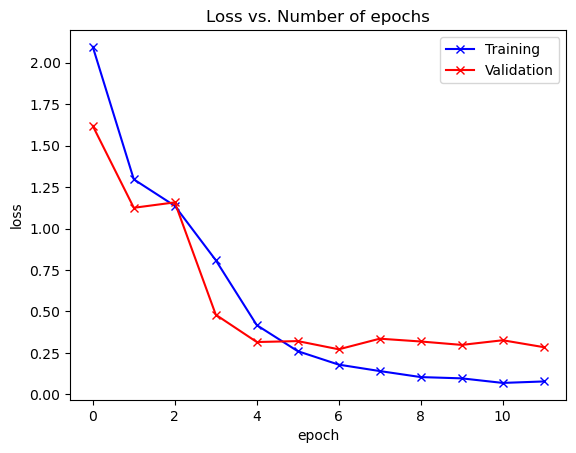

In [36]:
plot_losses(history)

As the number of epochs increases, both the training loss and the validation loss decreases which is consistent with the theory. However, I noticed an interesting behaviour for the validation loss. After a certain number of epochs (in this case 6), the validation loss (red curve) stops decreasing by much. If I added more epochs to my model, we would even see the validation loss begininng to increase again due to the concept of OVERFITTING. 
After looking at these plots, I think my current model has a good tradeoff between the bias and the variance.

In [37]:
# Just for fun, here is the accuracy of the model on the training set:
x = np.load('datasets/x_train.npy') #11,000 x 64 x 64
y = np.load('datasets/y_train.npy')
yh = predict(model, x[:8800])  
print("The accuracy of the model on the training set is", accuracy_score(y[:8800], yh))

The accuracy of the model on the training set is 0.9811363636363636
